---
This notebook will take an image of a hand of cards and it will identify individual cards.

---

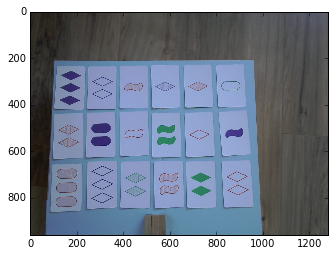

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt


image = cv2.imread('irl-dealt-hand-images/dealt-hand-1.png')
image = cv2.cvtColor(image, cv2.cv.CV_BGR2RGB)

_ = plt.imshow(image)

---
Crop and transform.

---

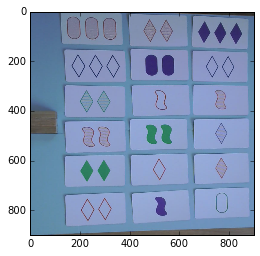

In [35]:
import numpy as np


# Find contours.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (1,1), 10)
_, thresholded = cv2.threshold(blur, 118, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

rect = cv2.minAreaRect(contours[0])
r = np.array(cv2.cv.BoxPoints(rect), np.float32)

size = 900
h = np.array([[0, 0], [size, 0], [size, size], [0, size]], np.float32)
transform = cv2.getPerspectiveTransform(r, h)
warp = cv2.warpPerspective(image, transform, (size, size))

_ = plt.imshow(warp)

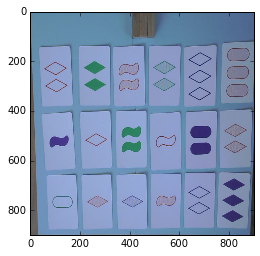

In [36]:
# rotate the image by 270 degrees
h, w = warp.shape[:2]
center = (w/2, h/2)
M = cv2.getRotationMatrix2D(center, 270, 1.0)
warp = cv2.warpAffine(warp, M, (w, h))

_ = plt.imshow(warp)

---
Threshold with color filtering.

---

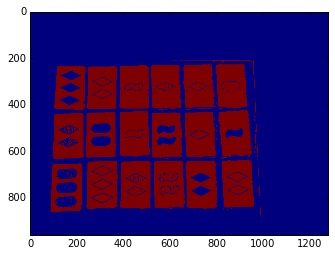

In [37]:
sensitivity = 100
lower_white = np.array([0, 0, 255-sensitivity])
upper_white = np.array([255, sensitivity, 255])
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
thresh = cv2.inRange(hsv_img, lower_white, upper_white)
_ = plt.imshow(thresh)

---
Look for cards.

---

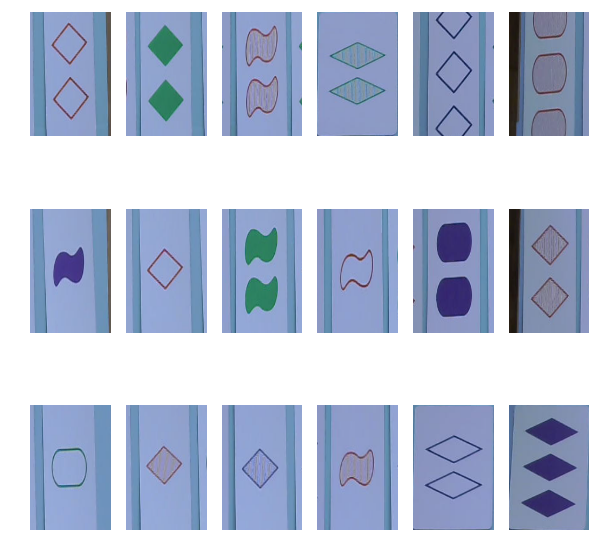

In [38]:
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[0:18]

# Sort contours by distance from top left.
rectangles, nw_corners = [], []
for contour in contours:
  rect = cv2.minAreaRect(contour)
  
  rotated = list(rect)
  rotated[2] = 90
  rect = tuple(rotated)

  points = np.array(cv2.cv.BoxPoints(rect), np.float32)
  rectangles.append(points)
  # Find NW corner.
  west_points = sorted(points, key=lambda p: p[0])[:2]
  north_points = sorted(west_points, key=lambda p: p[1])
  nw_corners.append(north_points[0])

nw_corners = sorted(nw_corners, key=lambda p: p[1], reverse=True)
top_row = sorted(nw_corners[0:6], key=lambda p: p[0], reverse=True)
middle_row = sorted(nw_corners[6:12], key=lambda p: p[0], reverse=True)
bottom_row = sorted(nw_corners[12:18], key=lambda p: p[0], reverse=True)

top_row.extend(middle_row)
top_row.extend(bottom_row)
ordered_corners = top_row


figure = plt.figure(figsize=(10, 10))
width = 150
aspect_ratio = 0.64
height = int(width / aspect_ratio)
for index, corner in enumerate(ordered_corners):
  for points in rectangles:
    if corner not in points:
      continue
    h = np.array([[0, 0], [width, 0], [width, height], [0, height]], np.float32)
    transform = cv2.getPerspectiveTransform(points, h)
    warp = cv2.warpPerspective(image, transform, (width, height))
    plt.subplot(3, 6, index+1)
    plt.axis('off')
    plt.imshow(warp)